# Multi-Layer QG (Revised)

In [7]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import jax.random as jrandom
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Equations


$$
\partial_t q_k + (u_kq_k)_x + (v_kq_k)_y = F_k + D_k
$$ (eq:qg_form_adv)

The term that links each of the layers together, $\mathbf{A}$, is a tri-diagonal matrix that can be written as

$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_2'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In the paper [[Thiry et al., 2023](https://doi.org/10.22541/essoar.167397445.54992823/v1)], they use the following method

$$
\begin{aligned}
\text{Hyperviscosity}: && 
\boldsymbol{D_1} &= 
-a_4\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

### Heights


$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_1'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In [ ]:
A = 

### Helmholtz Matrices

We can precompute the Helmoltz matrices

$$
\text{Helmholtz}:=\left(\alpha\boldsymbol{\nabla}-\beta\right)u
$$

where

$$
\begin{aligned}
\alpha &= \frac{1}{f_0^2} \\
\beta &= \lambda
\end{aligned}
$$

In [ ]:
def compute_layer_to_mode_matrices(A):
    # eigenvalue decomposition
    lambd_r, R = jnp.linalg.eig(A)
    _, L = jnp.linalg.eig(A.T)

    # extract real components
    lambd, R, L = lambd_r.real, R.real, L.real

    # create matrices
    Cl2m = np.diag(1.0 / np.diag(L.T @ R)) @ L.T
    Cm2l = R
    # create diagonal matrix
    return lambd, -Cl2m, -Cm2l

## Helmholtz Decomposition

In [8]:
N = 8
nx, ny = 2*2**(N-1), 2*2**(N-1)
shape = (nx, ny)

L = 2_000e3

xc = jnp.linspace(-L, L, nx+1)
yc = jnp.linspace(-L, L, ny+1)

xx, yy = jnp.meshgrid(xc, yc, indexing="ij")

dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

**Helmholtz Equation**

In [17]:
from jaxsw._src.operators.functional.dst import helmholtz_dist, laplacian_dist, inverse_elliptical_dst_solver, inverse_elliptic_dst

In [165]:
def laplacian_dist(nx, ny, dx, dy, mean: bool = True) -> Array:
    if mean:
        dx = dy = jnp.mean(jnp.asarray([dx, dy]))

    x, y = jnp.meshgrid(
        jnp.arange(1, nx-1, dtype=dx.dtype),
        jnp.arange(1, ny-1, dtype=dx.dtype),
        indexing="ij"
    )

    return (
        2 * (jnp.cos(jnp.pi / nx * x) - 1) / dx**2
        + 2 * (jnp.cos(jnp.pi / ny * y) - 1) / dy**2
    )

In [166]:
def helmholtz_fn(u, dx, dy, beta):
    d2u_dx2 = (u[...,2:,1:-1] + u[...,:-2,1:-1] - 2*u[..., 1:-1,1:-1]) / dx**2
    d2u_dy2 = (u[...,1:-1,2:] + u[...,1:-1,:-2] - 2*u[...,1:-1,1:-1]) / dy**2
    return d2u_dx2 + d2u_dy2 - beta * u[..., 1:-1,1:-1]

In [167]:
beta = 1.0

H_matrix = laplacian_dist(nx, ny, dx, dy) - beta

print(H_matrix.shape, nx, ny)

(254, 254) 256 256


In [168]:
# create random matrix
key = jrandom.PRNGKey(42)
Frect = jnp.zeros(shape=(nx,ny))
Frect = Frect.at[1:-1,1:-1].set(jrandom.normal(key=key, shape=(nx-2,ny-2)))


Hfrect = helmholtz_fn(Frect, dx, dy, beta)
Hfrect.shape

(254, 254)

In [169]:
Frect_r = inverse_elliptic_dst(Frect[1:-1,1:-1], H_matrix)

In [170]:
Frect_r.shape, Frect.shape

((256, 256), (256, 256))

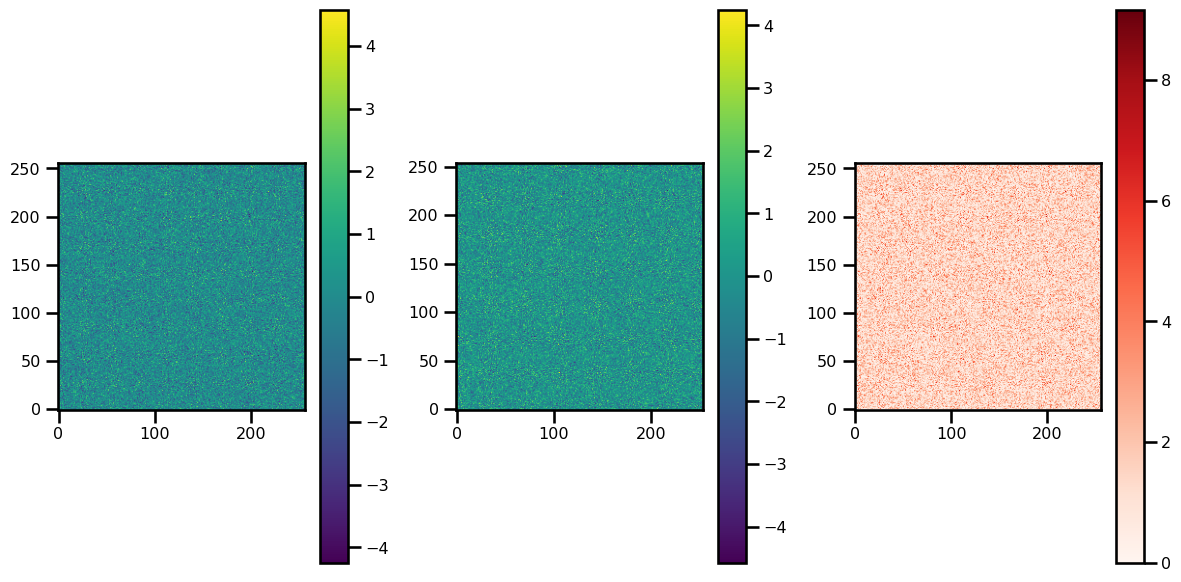

In [172]:
fig, ax = plt.subplots(ncols=3, figsize=(12,6))

pts = ax[0].imshow(Frect.T, origin="lower")
plt.colorbar(pts)

pts = ax[1].imshow(Frect_r[1:-1,1:-1].T, origin="lower")
plt.colorbar(pts)

pts = ax[2].imshow(np.abs(Frect - Frect_r).T, origin="lower", cmap="Reds")
plt.colorbar(pts)

plt.tight_layout()
plt.show()